In [1]:
import sys, platform, os
import numpy as np
from scipy.interpolate import CubicSpline
from scipy.optimize import root_scalar
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib import rc
# import seaborn as sns

# Global definition of matplotlib plots appearance

plt.rcParams['mathtext.default']= 'regular'
plt.rcParams['legend.fontsize'] = 15
plt.rcParams['axes.labelsize'] = 15
plt.rcParams["axes.labelpad"]=10             # axes labels distance from tick labels
plt.rcParams["axes.titlesize"] = 15
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['lines.linewidth'] = 2.2
plt.rcParams['figure.dpi'] = 400             #  figure dimension in dpi

camb_installation_path = './../' 
camb_path = os.path.realpath(os.path.join(os.getcwd(),camb_installation_path))
sys.path.insert(0,camb_path)
import camb

In [2]:
alpha_list = ['alphaK', 'alphaB', 'alphaM', 'alphaT']

alpha_value_list = {'alphaK':{'alphaK': 0.1, 'alphaB': 0.0, 'alphaM': 0.0, 'alphaT': 0.0},
                    'alphaB':{'alphaK': 0.1, 'alphaB': -0.5, 'alphaM': 0.0, 'alphaT': 0.0},
                    'alphaM':{'alphaK': 0.1, 'alphaB': 0.0, 'alphaM': 0.2, 'alphaT': 0.0},
                    'alphaT':{'alphaK': 0.1, 'alphaB': 0.0, 'alphaM': 0.0, 'alphaT': -0.2}}

In [3]:
cls_camb_dict = {}
pk_camb_dict = {}
k_camb_dict = {}

for alpha in alpha_list:

    params_camb = {
    # config
    'lmax': 10000,
    'kmax': 2,
    'lens_potential_accuracy': 1,
    'nonlinear': 0,
    # cosmo
    'ombh2': 0.022,
    'omch2': 0.12,
    'H0': 67.5,
    'tau':0.055,
    'ns': 0.965,
    'As': 2.1e-09,
    'num_massive_neutrinos': 0,
    'mnu': 0,
    'nnu': 3.044,
    # MG
    'dark_energy_model': 'EFTCAMB',
    'EFTflag' : 2,
    'AltParEFTmodel':1,
    'RPHintegratefromtoday': False,
    'RPHusealphaM': True,
    'RPHkineticitymodel_ODE': 2,
    'RPHkineticity_ODE0': alpha_value_list[alpha]['alphaK'],
    'RPHbraidingmodel_ODE': 2,
    'RPHbraiding_ODE0': alpha_value_list[alpha]['alphaB'],
    'RPHalphaMmodel_ODE': 2,
    'RPHalphaM_ODE0': alpha_value_list[alpha]['alphaM'],
    'RPHtensormodel_ODE': 2,
    'RPHtensor_ODE0': alpha_value_list[alpha]['alphaT'],
    'EFTCAMB_back_turn_on': 1e-8,
    'EFTCAMB_turn_on_time': 1e-8,
    'EFTCAMB_skip_stability': True,
    'feedback_level': 0,
  }
    pars = camb.set_params(**params_camb)
    rlts = camb.get_results(pars)

    cls = rlts.get_cmb_power_spectra(pars, CMB_unit=None)['total']
    k, z, pk = rlts.get_linear_matter_power_spectrum(var1='delta_tot', var2='delta_tot', hubble_units=False, k_hunit=False)
    pk_last = pk[-1, :]

    # save the results in the dictionary
    cls_camb_dict[alpha] = cls
    pk_camb_dict[alpha] = pk_last
    k_camb_dict[alpha] = k

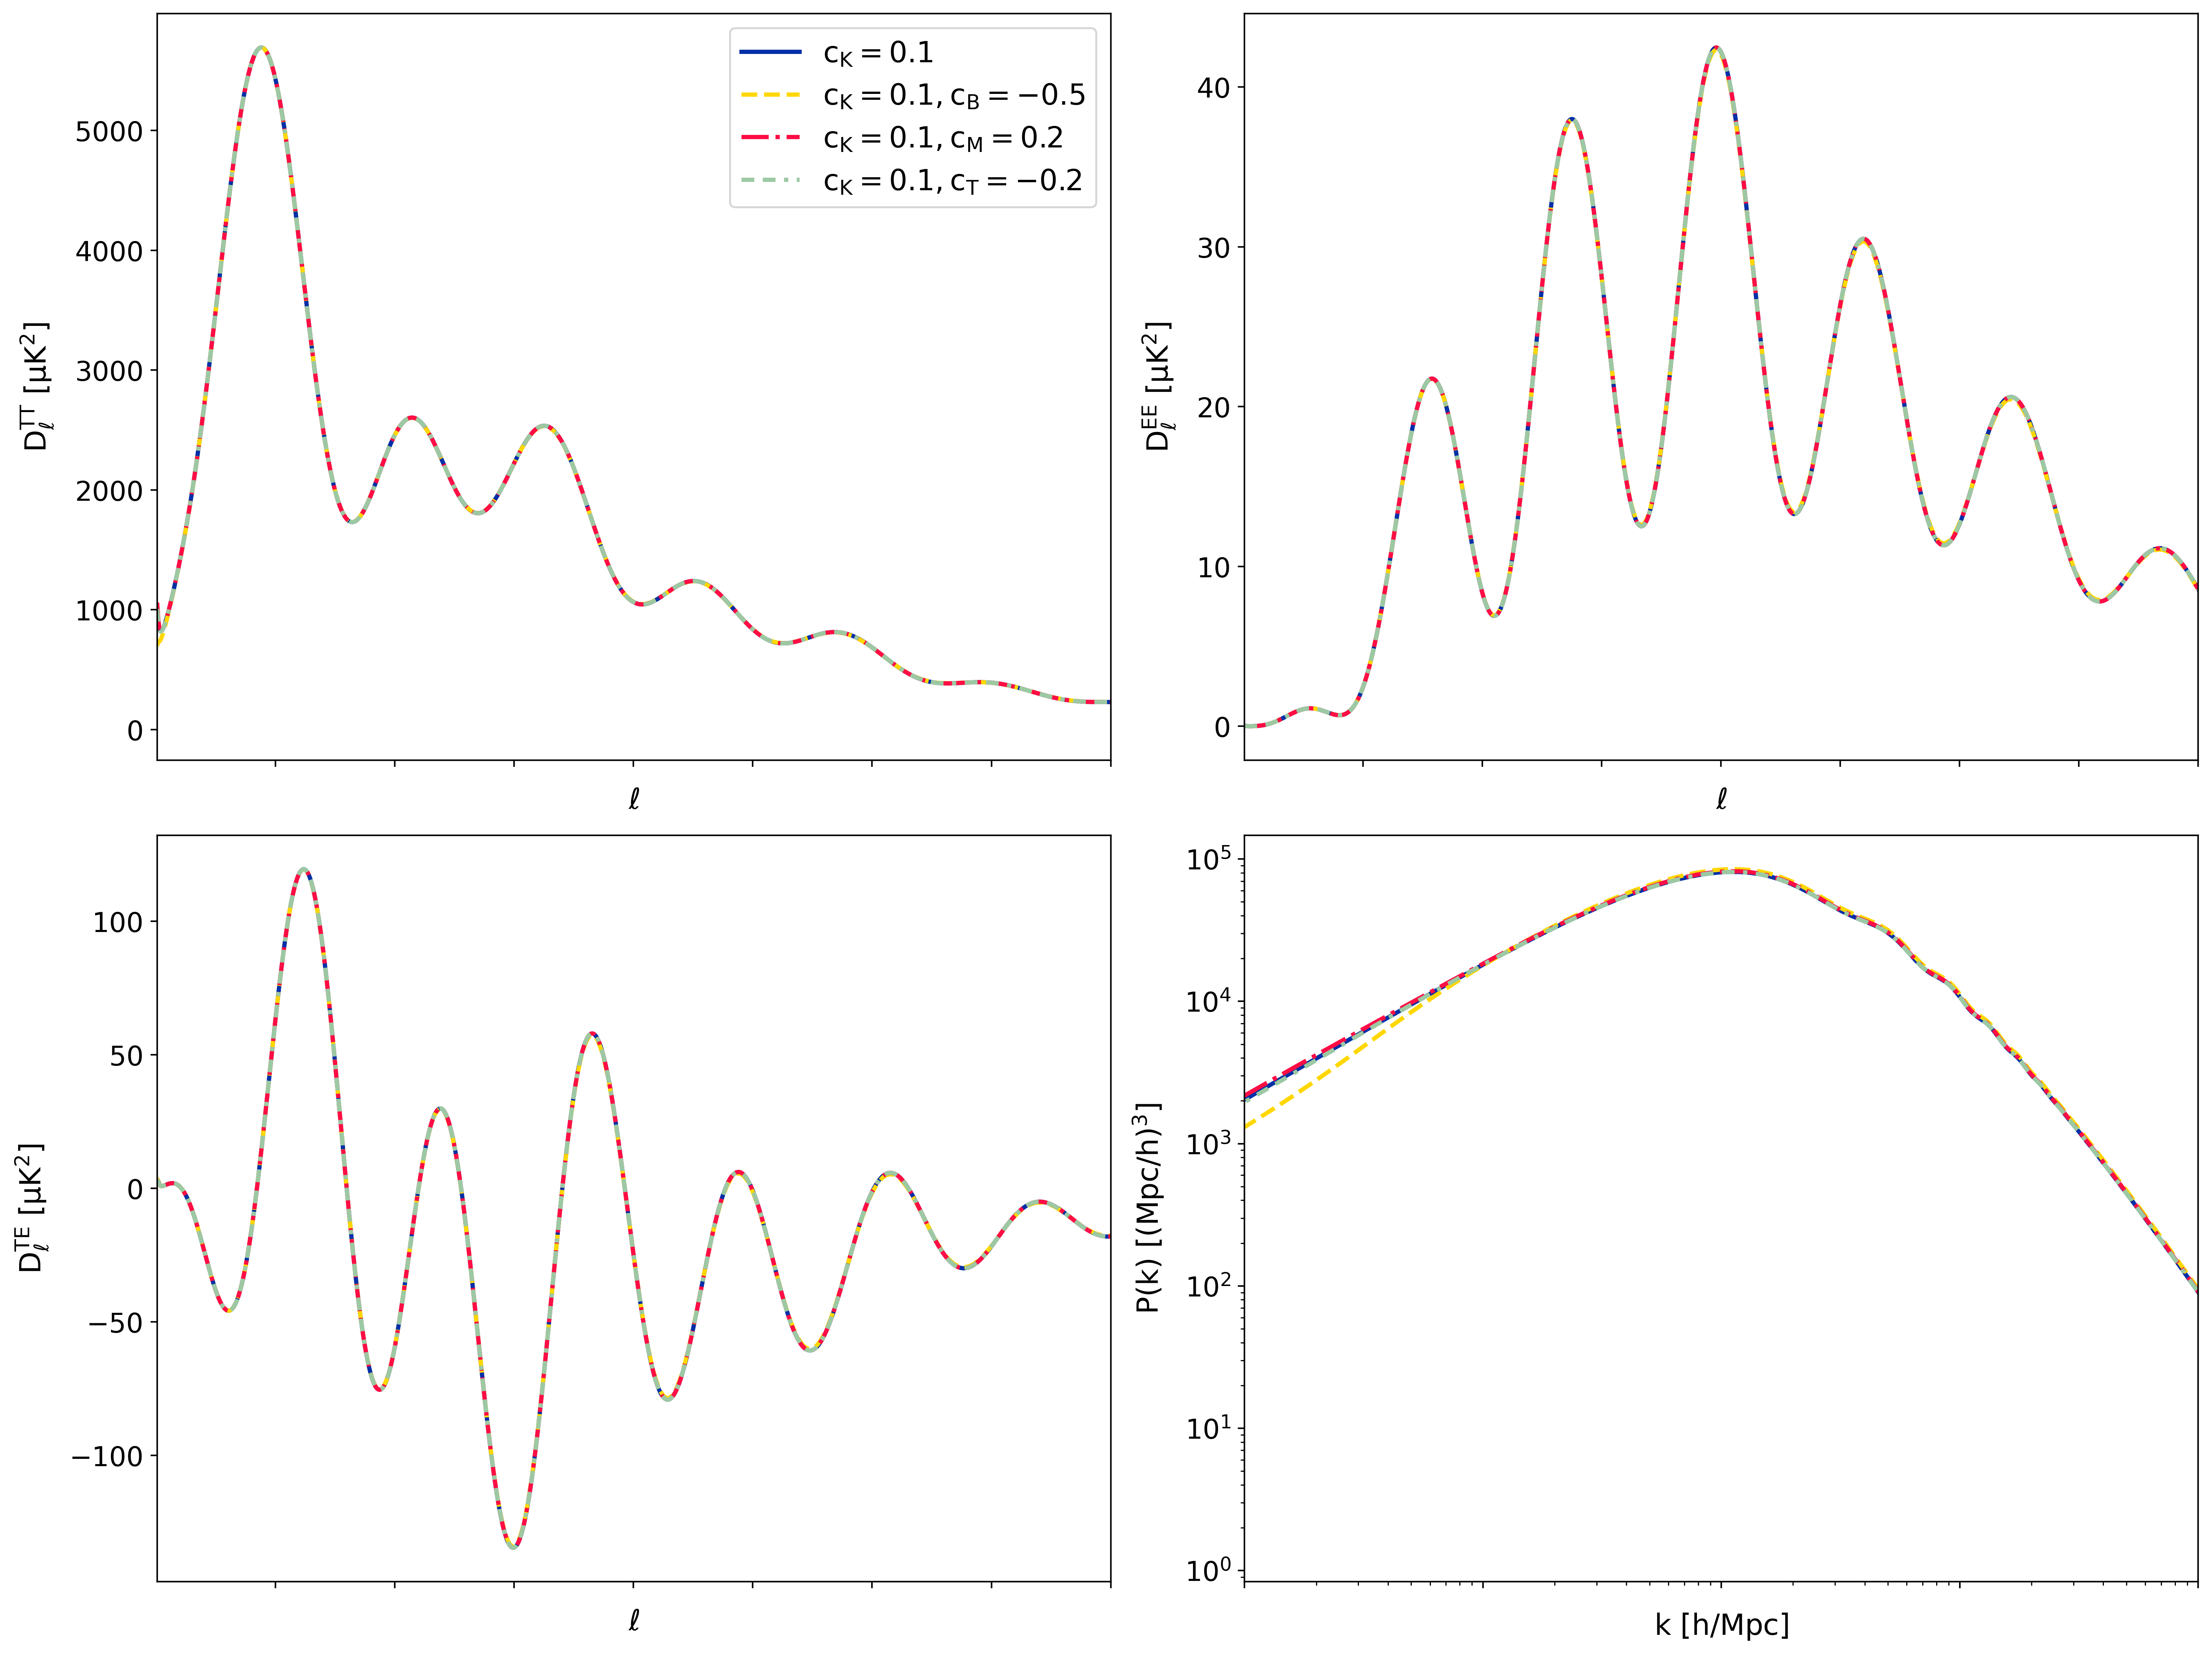

In [7]:
# ======= Plotting setup =======
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# ======= Start plotting =======

colors = ['#002FA7', '#FFD700',"#FF0D45", '#9CC9A3', ]
linestyles = ['-', '--', '-.', (0, (3, 2, 3, 2, 1, 2))]
alpha_list = ['alphaK', 'alphaB', 'alphaM', 'alphaT']
labels = [r'$c_K=0.1$', r'$c_K=0.1, c_B=-0.5$', r'$c_K=0.1, c_M=0.2$', r'$c_K=0.1, c_T=-0.2$']

for alpha, color, ls, label in zip(alpha_list, colors, linestyles, labels):

    cls_camb_alpha = cls_camb_dict[alpha]* (2.7255e6)**2
    pk_camb_alpha = pk_camb_dict[alpha]
    k_camb_alpha = k_camb_dict[alpha]

    pkitp = CubicSpline(np.log(k_camb_alpha), np.log(pk_camb_alpha))
    pkf = lambda k: np.exp(pkitp(np.log(k)))

    l = np.arange(cls_camb_alpha.shape[0])[2:3000]

    # --- TT ---
    axes[0][0].plot(l, cls_camb_alpha[2:3000, 0], color=color, ls=ls, label=label)

    # --- EE ---
    axes[0][1].plot(l, cls_camb_alpha[2:3000, 1], color=color, ls=ls, label=label)

    # --- TE ---
    axes[1][0].plot(l, cls_camb_alpha[2:3000, 3], color=color, ls=ls, label=label)

    # --- P(k) ---
    axes[1][1].loglog(k_camb_alpha, pk_camb_alpha, color=color, ls=ls, label=label)

# TT
axes[0][0].set_xlim([2, 2000])
axes[0][0].set_ylabel(r'$D_\ell^{TT}$ [$\mu K^2$]')
axes[0][0].tick_params(labelbottom=False)
axes[0][0].legend()
axes[0][0].set_xlabel(r'$\ell$')

# EE
axes[0][1].set_xlim([2, 2000])
axes[0][1].set_ylabel(r'$D_\ell^{EE}$ [$\mu K^2$]')
axes[0][1].tick_params(labelbottom=False)
axes[0][1].set_xlabel(r'$\ell$')

# TE
axes[1][0].set_xlim([2, 2000])
axes[1][0].set_ylabel(r'$D_\ell^{TE}$ [$\mu K^2$]')
axes[1][0].tick_params(labelbottom=False)
axes[1][0].set_xlabel(r'$\ell$')


# P(k)
axes[1][1].set_xlim([1e-4, 1])
axes[1][1].set_ylabel(r'$P(k)$ [$(Mpc/h)^3$]')
axes[1][1].tick_params(labelbottom=False)
axes[1][1].set_xlabel(r'$k$ [$h/Mpc$]')

plt.tight_layout()
plt.show()
